In [1]:
#Chargement des modules commun
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import *
from sklearn.compose import *
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler  

In [2]:
def transformLabelIntoMultiClass(df: pd.DataFrame):
    X = df.drop('revenue', axis=1)
    y = df['revenue']
    
    # Apply the transformation to make the distribution more normal
    pt = PowerTransformer()
    y_transformed = pt.fit_transform(y.values.reshape(-1, 1))
    
    # Calculate the mean (M) and standard deviation (E) of the new distribution
    M = y_transformed.mean()
    E = y_transformed.std()
    
    min_trshld = M - 2 * E
    max_trshld = M + 2 * E
    print(f"Tresholds {min_trshld} | {max_trshld}")
    # Use np.where to create a new column 'revenue_category' based on conditions
    df['revenue'] = np.where(y_transformed < min_trshld, 0,
                                      np.where(y_transformed > max_trshld, 2, 1))
    
    return df

def getStartifiedResampled(df: pd.DataFrame,number_samples=2000, targetedColumn='revenue') -> pd.DataFrame:
    resampled_df = resample(df, n_samples=number_samples, replace=False, stratify=df[targetedColumn], random_state=5)
    return resampled_df

def cvs_wrapper(model, X_data, Y_data, value_count, scenario):

    kfold = [3]

    for fold in kfold:

        scores =[]
        scores = cross_val_score(model, X_data, Y_data, cv=fold, scoring="precision")
        scores_recall = cross_val_score(model, X_data, Y_data, cv=fold, scoring="recall")
        scores_f1 = cross_val_score(model, X_data,Y_data,cv=fold, scoring="f1")
        scores_accuracy = cross_val_score(model, X_data,Y_data,cv=fold, scoring="accuracy")

        scores = pd.DataFrame(scores, columns=['precision'])
        scores['recall'] = scores_recall
        scores['F1'] = scores_f1
        scores['accuracy']=scores_accuracy

        print("Scores de validation croisée pour un échantillon de", value_count, "instances,", fold, "plis (folds), sur des données", scenario, ":")
        print(scores.sort_values(by=['F1'], ascending=False))
        print("\n")
        
def get_XY_separated(df: pd.DataFrame):
    return df.iloc[:,:-1],df['revenue']

def normalisation_data(df: pd.DataFrame):
    scaler = StandardScaler()  
    scaler.fit(df)  
    df = scaler.transform(df) 
    return df

data = pd.read_csv('devoir1_df.csv')
data = data.drop(['population', 'GDP_inhab'], axis=1)

data = transformLabelIntoMultiClass(data)
# 0 correspond à un revenu bas
# 1 correspond à un revenu moyen
# 2 correspond à un revenu haut
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(data, test_size=0.2, 
                                       random_state=42)


Tresholds -2.0 | 1.9999999999999996


### 2.1 - Vous devez donc déterminer l’architecture du PMC en termes de nombre de couches 
### cachées et de nombre de neurones par couche cachée. Ça sera les mêmes contraintes 
### que le cas précédent, par rapport aux nombre de couches cachées, de neurones par 
### couches cachées et de la fonction d’activation de ces neurones. Cette architecture doit 
### être la plus performante en termes d’exactitude (accuracy)

In [3]:
# Echantillonnage aléatoire stratifié
sample_size = [2000, 4000, 8000]
train_set = pd.get_dummies(train_set[train_set.columns[:-1]])
train_set['revenue'] = data['revenue']
train_set = transformLabelIntoMultiClass(train_set)
 

train_set_R_samp1 = getStartifiedResampled(train_set,number_samples=sample_size[0])
train_set_R_samp2 = getStartifiedResampled(train_set,number_samples=sample_size[1])
train_set_R_samp3 = getStartifiedResampled(train_set,number_samples=sample_size[2])


Tresholds -2.0 | 2.000000000000001


In [4]:
# Validation croisée 

from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='sgd',random_state=42)

X_train_samp1, Y_train_samp1 = get_XY_separated(train_set_R_samp1)
X_train_samp2, Y_train_samp2 = get_XY_separated(train_set_R_samp2)
X_train_samp3, Y_train_samp3 = get_XY_separated(train_set_R_samp3)

X_train_samp1 = normalisation_data(X_train_samp1)
X_train_samp2 = normalisation_data(X_train_samp2)
X_train_samp3 = normalisation_data(X_train_samp3)

cvs_wrapper(clf, X_train_samp1, Y_train_samp1, sample_size[0], "scenario1")
cvs_wrapper(clf, X_train_samp2, Y_train_samp2, sample_size[1], "scenario1")
cvs_wrapper(clf, X_train_samp3, Y_train_samp3, sample_size[2], "scenario1")

D:\UQAC\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\UQAC\ML\lib\site-packages\sklearn\model_selection\_validation.py:842: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\UQAC\ML\lib\site-packages\sklearn\metrics\_scorer.py", line 136, in __call__
    score = scorer._score(
  File "D:\UQAC\ML\lib\site-packages\sklearn\metrics\_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "D:\UQAC\ML\lib\site-packages\sklearn\utils\_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "D:\UQAC\ML\lib\site-packages\sklearn\metrics\_classification.py", line 2127, in precision_score
    p, _, _, _ = precision_recall_fscore_suppor

Scores de validation croisée pour un échantillon de 2000 instances, 3 plis (folds), sur des données scenario1 :
   precision  recall  F1  accuracy
0        NaN     NaN NaN  0.967016
1        NaN     NaN NaN  0.967016
2        NaN     NaN NaN  0.968468




D:\UQAC\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\UQAC\ML\lib\site-packages\sklearn\model_selection\_validation.py:842: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\UQAC\ML\lib\site-packages\sklearn\metrics\_scorer.py", line 136, in __call__
    score = scorer._score(
  File "D:\UQAC\ML\lib\site-packages\sklearn\metrics\_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "D:\UQAC\ML\lib\site-packages\sklearn\utils\_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "D:\UQAC\ML\lib\site-packages\sklearn\metrics\_classification.py", line 2127, in precision_score
    p, _, _, _ = precision_recall_fscore_suppor

Scores de validation croisée pour un échantillon de 4000 instances, 3 plis (folds), sur des données scenario1 :
   precision  recall  F1  accuracy
0        NaN     NaN NaN  0.967016
1        NaN     NaN NaN  0.967742
2        NaN     NaN NaN  0.967742




D:\UQAC\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\UQAC\ML\lib\site-packages\sklearn\model_selection\_validation.py:842: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\UQAC\ML\lib\site-packages\sklearn\metrics\_scorer.py", line 136, in __call__
    score = scorer._score(
  File "D:\UQAC\ML\lib\site-packages\sklearn\metrics\_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "D:\UQAC\ML\lib\site-packages\sklearn\utils\_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "D:\UQAC\ML\lib\site-packages\sklearn\metrics\_classification.py", line 2127, in precision_score
    p, _, _, _ = precision_recall_fscore_suppor

Scores de validation croisée pour un échantillon de 8000 instances, 3 plis (folds), sur des données scenario1 :
   precision  recall  F1  accuracy
0        NaN     NaN NaN  0.967379
1        NaN     NaN NaN  0.967379
2        NaN     NaN NaN  0.967367




D:\UQAC\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Nous constatons que les meilleur résulats viennent du modèle avec les paramètres :

- 2000 instances
- 3 plis
- accuracy_score : 0.968
- F1 : Nan
- recall : Nan
- precision : Nan

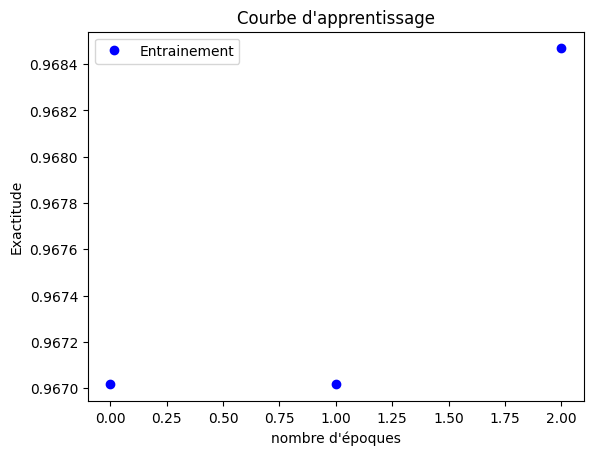

In [5]:
import matplotlib.pyplot as plt

plt.clf()
acc_values = [0.967016,0.967016,0.968468]

plt.plot([0,1,2], acc_values, 'bo', label='Entrainement')


plt.title('Courbe d\'apprentissage')
plt.xlabel('nombre d\'époques')
plt.ylabel('Exactitude')
plt.legend()
plt.show()

In [6]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from itertools import product
mlp = MLPClassifier(solver='sgd',random_state=42)
mlp.n_outputs_=2

hidden_layer_sizes = [(n,) for n in range(10, 101, 10)] 

all_hidden_layers = []

for num_layers in range(2, 6):
    for layers in product(hidden_layer_sizes, repeat=num_layers):
        flattened_layers = sum(layers, ())  
        if sum(flattened_layers) >= 20:  
            all_hidden_layers.append(flattened_layers)


all_hidden_layers
activation_options = ['tanh', 'relu']
solver_options = ['sgd', 'adam']
max_iter_options = [1000, 3500]
learning_rate_options = ['constant','adaptive']

parameter_space = {
        'hidden_layer_sizes': all_hidden_layers,
        'activation': activation_options,
        'solver': solver_options,
        'max_iter': max_iter_options,
        'learning_rate': learning_rate_options,
    }
    
clf = RandomizedSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)

clf.fit(X_train_samp1,Y_train_samp1 )

clf.best_params_

{'solver': 'sgd',
 'max_iter': 1000,
 'learning_rate': 'constant',
 'hidden_layer_sizes': (10, 30, 60, 90, 80),
 'activation': 'tanh'}

In [7]:
# Test avec un jeu de test
test_set = pd.get_dummies(test_set[test_set.columns[:-1]])
test_set['revenue'] = data['revenue']
test_set = transformLabelIntoMultiClass(test_set)
X_test, y_test = get_XY_separated(test_set)
y_pred = clf.predict(X_test)
from sklearn.metrics import classification_report
print('Results on the test set:')
print(classification_report(y_test, y_pred))

Tresholds -1.9999999999999991 | 2.000000000000001
Results on the test set:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        39
           1       0.97      1.00      0.98      1939
           2       0.00      0.00      0.00        22

    accuracy                           0.97      2000
   macro avg       0.32      0.33      0.33      2000
weighted avg       0.94      0.97      0.95      2000



D:\UQAC\ML\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
D:\UQAC\ML\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\UQAC\ML\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\UQAC\ML\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


2.1.7 ************

L'accuracy dans le devoir numéro 2 était de 0.51 pour le classeur MultiClass , ici nous constatons une nette augmentation car
l'accuracy est à 0.97.

### 2.2 La fonction d’activation des neurones de la couche de sortie reste à déterminer par 
### vous.

Vu que l'on utilise un classeur MultiClass nous allons utiliser une régression Softmax en fonction d'activation de sortie

In [8]:
clf.out_activation = 'softmax'